##### Copyright 2019 The TensorFlow Authors.

In [17]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tuning a BERT model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/docs/nlp/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/docs/nlp/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/docs/nlp/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial demonstrates how to fine-tune a [Bidirectional Encoder Representations from Transformers (BERT)](https://arxiv.org/abs/1810.04805) (Devlin et al., 2018) model using [TensorFlow Model Garden](https://github.com/tensorflow/models).

You can also find the pre-trained BERT model used in this tutorial on [TensorFlow Hub (TF Hub)](https://tensorflow.org/hub). For concrete examples of how to use the models from TF Hub, refer to the [Solve Glue tasks using BERT](https://www.tensorflow.org/text/tutorials/bert_glue) tutorial. If you're just trying to fine-tune a model, the TF Hub tutorial is a good starting point.

On the other hand, if you're interested in deeper customization, follow this tutorial. It shows how to do a lot of things manually, so you can learn how you can customize the workflow from data preprocessing to training, exporting and saving the model.

## Setup

### Install pip packages

Start by installing the TensorFlow Text and Model Garden pip packages.

*  `tf-models-official` is the TensorFlow Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` GitHub repo. To include the latest changes, you may install `tf-models-nightly`, which is the nightly Model Garden package created daily automatically.
*  pip will install all models and dependencies automatically.

In [18]:
!pip install -q opencv-python 

In [25]:
!pip install -q -U "tensorflow-text==2.10.0" 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboardx 2.6.2.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-datasets 4.9.4 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tf-models-official 2.15.0 requires tensorflow~=2.15.0, but you have tensorflow 2.10.1 which is incompatible.
tf-models-official 2.15.0 requires tensorflow-text~=2.15.0, but you have tensorflow-text 2.10.0 which is incompatible.


In [20]:
!pip install -r https://raw.githubusercontent.com/tensorflow/models/master/official/requirements.txt

  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached protobuf-3.20.3-cp310-cp310-win_amd64.whl.metadata (698 bytes)
Using cached protobuf-3.20.3-cp310-cp310-win_amd64.whl (904 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tf-models-official 2.15.0 requires tensorflow~=2.15.0, but you have tensorflow 2.10.1 which is incompatible.
tf-models-official 2.15.0 requires tensorflow-text~=2.15.0, but you have tensorflow-text 2.10.0 which is incompatible.


In [21]:
!pip install tf-models-official --no-deps

### Import libraries

In [22]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

### Resources

The following directory contains the BERT model's configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [26]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

NotFoundError: Could not find directory gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12

## Load and preprocess the dataset

This example uses the GLUE (General Language Understanding Evaluation) MRPC (Microsoft Research Paraphrase Corpus) [dataset from TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc).

This dataset is not set up such that it can be directly fed into the BERT model. The following section handles the necessary preprocessing.

### Get the dataset from TensorFlow Datasets

The GLUE MRPC (Dolan and Brockett, 2005) dataset is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent. It has the following attributes:

*   Number of labels: 2
*   Size of training dataset: 3668
*   Size of evaluation dataset: 408
*   Maximum sequence length of training and evaluation dataset: 128

Begin by loading the MRPC dataset from TFDS:

In [ ]:
batch_size=32
glue, info = tfds.load('glue/mrpc',
                       with_info=True,
                       batch_size=32)

In [ ]:
glue

{'train': <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 'validation': <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 'test': <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>}

The `info` object describes the dataset and its features:

In [ ]:
info.features

FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=string),
    'sentence2': Text(shape=(), dtype=string),
})

The two classes are:

In [ ]:
info.features['label'].names

['not_equivalent', 'equivalent']

Here is one example from the training set:

In [ ]:
example_batch = next(iter(glue['train']))

for key, value in example_batch.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


2024-02-07 12:13:45.153482: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Preprocess the data

The keys `"sentence1"` and `"sentence2"` in the GLUE MRPC dataset contain two input sentences for each example.

Because the BERT model from the Model Garden doesn't take raw text as input, two things need to happen first:

1. The text needs to be _tokenized_ (split into word pieces) and converted to _indices_.
2. Then, the _indices_ need to be packed into the format that the model expects.

#### The BERT tokenizer

To fine tune a pre-trained language model from the Model Garden, such as BERT, you need to make sure that you're using exactly the same tokenization, vocabulary, and index mapping as used during training.

The following code rebuilds the tokenizer that was used by the base model using the Model Garden's `tfm.nlp.layers.FastWordpieceBertTokenizer` layer:

In [ ]:
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    lower_case=True)

Let's tokenize a test sentence:

In [ ]:
tokens = tokenizer(tf.constant(["Hello TensorFlow!"]))
tokens

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>

Learn more about the tokenization process in the [Subword tokenization](https://www.tensorflow.org/text/guide/subwords_tokenizer) and [Tokenizing with TensorFlow Text](https://www.tensorflow.org/text/guide/tokenizers) guides.

#### Pack the inputs

TensorFlow Model Garden's BERT model doesn't just take the tokenized strings as input. It also expects these to be packed into a particular format. `tfm.nlp.layers.BertPackInputs` layer can handle the conversion from _a list of tokenized sentences_ to the input format expected by the Model Garden's BERT model.

`tfm.nlp.layers.BertPackInputs` packs the two input sentences (per example in the MRCP dataset) concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token.

Therefore, the `tfm.nlp.layers.BertPackInputs` layer's constructor takes the `tokenizer`'s special tokens as an argument. It also needs to know the indices of the tokenizer's special tokens.

In [ ]:
special = tokenizer.get_special_tokens_dict()
special

{'vocab_size': 30522,
 'start_of_sequence_id': 101,
 'end_of_segment_id': 102,
 'padding_id': 0,
 'mask_id': 103}

In [ ]:
max_seq_length = 128

packer = tfm.nlp.layers.BertPackInputs(
    seq_length=max_seq_length,
    special_tokens_dict = tokenizer.get_special_tokens_dict())

The `packer` takes a list of tokenized sentences as input. For example:

In [ ]:
sentences1 = ["hello tensorflow"]
tok1 = tokenizer(sentences1)
tok1

<tf.RaggedTensor [[[7592], [23435, 12314]]]>

In [ ]:
sentences2 = ["goodbye tensorflow"]
tok2 = tokenizer(sentences2)
tok2

<tf.RaggedTensor [[[9119], [23435, 12314]]]>

Then, it returns a dictionary containing three outputs:

- `input_word_ids`: The tokenized sentences packed together.
- `input_mask`: The mask indicating which locations are valid in the other outputs.
- `input_type_ids`: Indicating which sentence each token belongs to.

In [ ]:
packed = packer([tok1, tok2])

for key, tensor in packed.items():
  print(f"{key:15s}: {tensor[:, :12]}")

input_word_ids : [[  101  7592 23435 12314   102  9119 23435 12314   102     0     0     0]]
input_mask     : [[1 1 1 1 1 1 1 1 1 0 0 0]]
input_type_ids : [[0 0 0 0 0 1 1 1 1 0 0 0]]


#### Put it all together

Combine these two parts into a `keras.layers.Layer` that can be attached to your model:

In [ ]:
class BertInputProcessor(tf.keras.layers.Layer):
  def __init__(self, tokenizer, packer):
    super().__init__()
    self.tokenizer = tokenizer
    self.packer = packer

  def call(self, inputs):
    tok1 = self.tokenizer(inputs['sentence1'])
    tok2 = self.tokenizer(inputs['sentence2'])

    packed = self.packer([tok1, tok2])

    if 'label' in inputs:
      return packed, inputs['label']
    else:
      return packed

But for now just apply it to the dataset using `Dataset.map`, since the dataset you loaded from TFDS is a `tf.data.Dataset` object:

In [ ]:
bert_inputs_processor = BertInputProcessor(tokenizer, packer)

In [ ]:
glue_train = glue['train'].map(bert_inputs_processor).prefetch(1)

Here is an example batch from the processed dataset:

In [ ]:
example_inputs, example_labels = next(iter(glue_train))

2024-02-07 12:13:49.744645: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
example_inputs

{'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[ 101, 1996, 7235, ...,    0,    0,    0],
        [ 101, 2625, 2084, ...,    0,    0,    0],
        [ 101, 6804, 1011, ...,    0,    0,    0],
        ...,
        [ 101, 2021, 2049, ...,    0,    0,    0],
        [ 101, 2274, 2062, ...,    0,    0,    0],
        [ 101, 2043, 1037, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
example_labels

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1])>

In [ ]:
for key, value in example_inputs.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'{"labels":15s} shape: {example_labels.shape}')

input_word_ids  shape: (32, 128)
input_mask      shape: (32, 128)
input_type_ids  shape: (32, 128)
labels          shape: (32,)


The `input_word_ids` contain the token IDs:

In [ ]:
plt.pcolormesh(example_inputs['input_word_ids'])

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

In [ ]:
plt.pcolormesh(example_inputs['input_mask'])

The "input type" also has the same shape, but inside the non-padded region, contains a `0` or a `1` indicating which sentence the token is a part of.

In [ ]:
plt.pcolormesh(example_inputs['input_type_ids'])

Apply the same preprocessing to the validation and test subsets of the GLUE MRPC dataset:

In [ ]:
glue_validation = glue['validation'].map(bert_inputs_processor).prefetch(1)
glue_test = glue['test'].map(bert_inputs_processor).prefetch(1)

## Build, train and export the model

Now that you have formatted the data as expected, you can start working on building and training the model.

### Build the model


The first step is to download the configuration file—`config_dict`—for the pre-trained BERT model:


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
encoder_config = tfm.nlp.encoders.EncoderConfig({
    'type':'bert',
    'bert': config_dict
})

In [ ]:
bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)
bert_encoder

The configuration file defines the core BERT model from the Model Garden, which is a Keras model that predicts the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

In [ ]:
bert_classifier = tfm.nlp.models.BertClassifier(network=bert_encoder, num_classes=2)

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [ ]:
bert_classifier(
    example_inputs, training=True).numpy()[:10]

array([[ 0.08335936,  1.1473498 ],
       [ 1.3190541 ,  1.3408866 ],
       [ 0.19908446,  0.7913456 ],
       [ 0.48186374,  1.2114024 ],
       [ 0.9708527 ,  0.7837988 ],
       [ 0.25541633,  0.76591694],
       [ 1.3683597 ,  1.0795705 ],
       [ 0.11288509,  1.1301354 ],
       [-0.02536219,  0.4678782 ],
       [ 0.9831672 ,  0.538211  ]], dtype=float32)

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

If you inspect the encoder, notice the stack of `Transformer` layers connected to those same three inputs:

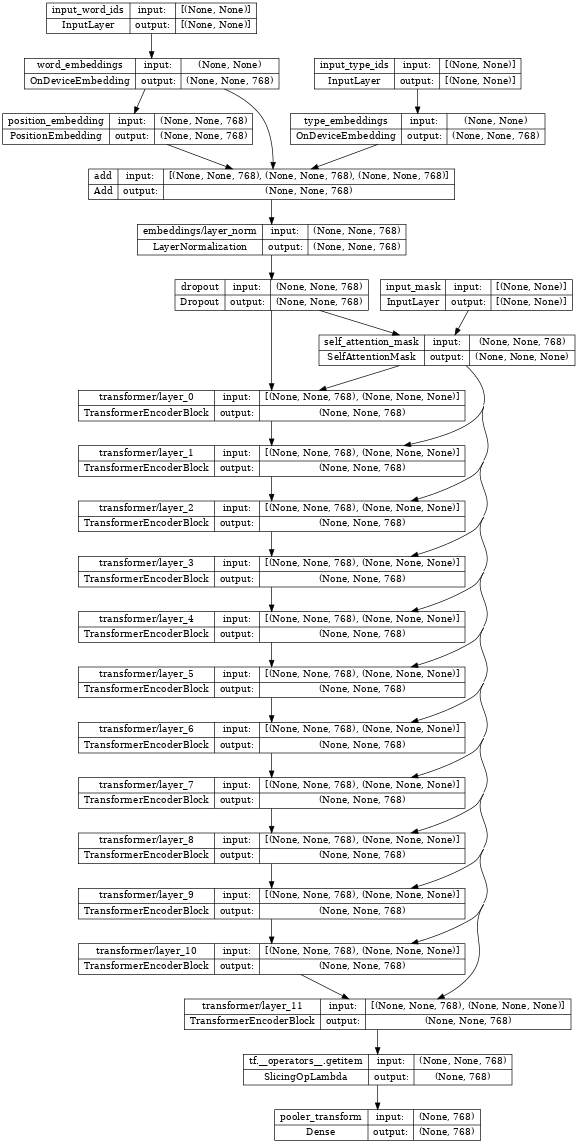

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights

When built, the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [ ]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pre-trained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). Go to the [TF Hub appendix](#hub_bert) for details.

### Set up the optimizer

BERT typically uses the Adam optimizer with weight decay—[AdamW](https://arxiv.org/abs/1711.05101) (`tf.keras.optimizers.experimental.AdamW`).
It also employs a learning rate schedule that first warms up from 0 and then decays to 0:

In [ ]:
# Set up epochs and steps
epochs = 5
batch_size = 32
eval_batch_size = 32

train_data_size = info.splits['train'].num_examples
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

Linear decay from `initial_learning_rate` to zero over `num_train_steps`.

In [ ]:
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

Warmup to that value over `warmup_steps`:

In [ ]:
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

The overall schedule looks like this:

In [ ]:
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

Text(0, 0.5, 'Learning rate')

Use `tf.keras.optimizers.experimental.AdamW` to instantiate the optimizer with that schedule:

In [ ]:
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

### Train the model

Set the metric as accuracy and the loss as sparse categorical cross-entropy. Then, compile and train the BERT classifier:

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [ ]:
bert_classifier.evaluate(glue_validation)


 1/13 [=>............................] - ETA: 34s - loss: 1.2873 - accuracy: 0.2500


 2/13 [===>..........................] - ETA: 2s - loss: 1.2193 - accuracy: 0.2969 


 3/13 [=====>........................] - ETA: 2s - loss: 1.2119 - accuracy: 0.3021


 4/13 [========>.....................] - ETA: 2s - loss: 1.2549 - accuracy: 0.2734


 5/13 [==========>...................] - ETA: 2s - loss: 1.2535 - accuracy: 0.2750


 6/13 [============>.................] - ETA: 1s - loss: 1.2233 - accuracy: 0.2969


 7/13 [===============>..............] - ETA: 1s - loss: 1.2202 - accuracy: 0.2991


 8/13 [=================>............] - ETA: 1s - loss: 1.2182 - accuracy: 0.3008


 9/13 [===================>..........] - ETA: 1s - loss: 1.1919 - accuracy: 0.3194


10/13 [======================>.......] - ETA: 0s - loss: 1.1933 - accuracy: 0.3187


11/13 [========================>.....] - ETA: 0s - loss: 1.1971 - accuracy: 0.3153


12/13 [==========================>...] - ETA: 0s - loss: 1.1900 - accuracy: 0.3203


13/13 [==============================] - ETA: 0s - loss: 1.1962 - accuracy: 0.3162


13/13 [==============================] - 6s 255ms/step - loss: 1.1962 - accuracy: 0.3162


[1.1962156295776367, 0.31617647409439087]

In [ ]:
bert_classifier.fit(
      glue_train,
      validation_data=(glue_validation),
      batch_size=32,
      epochs=epochs)

Epoch 1/5


I0000 00:00:1707308071.926522   10692 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



  1/115 [..............................] - ETA: 1:02:36 - loss: 1.2609 - accuracy: 0.3750


  2/115 [..............................] - ETA: 1:30 - loss: 1.3371 - accuracy: 0.2812   


  3/115 [..............................] - ETA: 1:27 - loss: 1.2942 - accuracy: 0.3125


  4/115 [>.............................] - ETA: 1:25 - loss: 1.3021 - accuracy: 0.3125


  5/115 [>.............................] - ETA: 1:24 - loss: 1.2611 - accuracy: 0.3375


  6/115 [>.............................] - ETA: 1:23 - loss: 1.2362 - accuracy: 0.3542


  7/115 [>.............................] - ETA: 1:22 - loss: 1.2500 - accuracy: 0.3527


  8/115 [=>............................] - ETA: 1:21 - loss: 1.2318 - accuracy: 0.3633


  9/115 [=>............................] - ETA: 1:20 - loss: 1.2067 - accuracy: 0.3576


 10/115 [=>............................] - ETA: 1:20 - loss: 1.1960 - accuracy: 0.3562


 11/115 [=>............................] - ETA: 1:19 - loss: 1.2083 - accuracy: 0.3466


 12/115 [==>...........................] - ETA: 1:18 - loss: 1.2031 - accuracy: 0.3438


 13/115 [==>...........................] - ETA: 1:17 - loss: 1.1856 - accuracy: 0.3534


 14/115 [==>...........................] - ETA: 1:17 - loss: 1.1790 - accuracy: 0.3549


 15/115 [==>...........................] - ETA: 1:16 - loss: 1.1840 - accuracy: 0.3521


 16/115 [===>..........................] - ETA: 1:15 - loss: 1.1572 - accuracy: 0.3633


 17/115 [===>..........................] - ETA: 1:14 - loss: 1.1556 - accuracy: 0.3548


 18/115 [===>..........................] - ETA: 1:14 - loss: 1.1476 - accuracy: 0.3542


 19/115 [===>..........................] - ETA: 1:13 - loss: 1.1357 - accuracy: 0.3586


 20/115 [====>.........................] - ETA: 1:12 - loss: 1.1272 - accuracy: 0.3625


 21/115 [====>.........................] - ETA: 1:11 - loss: 1.1230 - accuracy: 0.3616


 22/115 [====>.........................] - ETA: 1:11 - loss: 1.1170 - accuracy: 0.3608


 23/115 [=====>........................] - ETA: 1:10 - loss: 1.1150 - accuracy: 0.3573


 24/115 [=====>........................] - ETA: 1:09 - loss: 1.1050 - accuracy: 0.3581


 25/115 [=====>........................] - ETA: 1:08 - loss: 1.0844 - accuracy: 0.3713


 26/115 [=====>........................] - ETA: 1:08 - loss: 1.0677 - accuracy: 0.3822


 27/115 [======>.......................] - ETA: 1:07 - loss: 1.0494 - accuracy: 0.3947


 28/115 [======>.......................] - ETA: 1:06 - loss: 1.0368 - accuracy: 0.4085


 29/115 [======>.......................] - ETA: 1:06 - loss: 1.0283 - accuracy: 0.4159


 30/115 [======>.......................] - ETA: 1:05 - loss: 1.0116 - accuracy: 0.4292


 31/115 [=======>......................] - ETA: 1:04 - loss: 1.0041 - accuracy: 0.4375


 32/115 [=======>......................] - ETA: 1:03 - loss: 0.9931 - accuracy: 0.4473


 33/115 [=======>......................] - ETA: 1:03 - loss: 0.9815 - accuracy: 0.4574


 34/115 [=======>......................] - ETA: 1:02 - loss: 0.9878 - accuracy: 0.4586


 35/115 [========>.....................] - ETA: 1:01 - loss: 0.9795 - accuracy: 0.4661


 36/115 [========>.....................] - ETA: 1:00 - loss: 0.9793 - accuracy: 0.4688


 37/115 [========>.....................] - ETA: 1:00 - loss: 0.9695 - accuracy: 0.4780


 38/115 [========>.....................] - ETA: 59s - loss: 0.9636 - accuracy: 0.4811 


 39/115 [=========>....................] - ETA: 58s - loss: 0.9522 - accuracy: 0.4864


 40/115 [=========>....................] - ETA: 58s - loss: 0.9425 - accuracy: 0.4922


 41/115 [=========>....................] - ETA: 57s - loss: 0.9350 - accuracy: 0.4962


 42/115 [=========>....................] - ETA: 56s - loss: 0.9284 - accuracy: 0.5015


 43/115 [==========>...................] - ETA: 55s - loss: 0.9228 - accuracy: 0.5051


 44/115 [==========>...................] - ETA: 55s - loss: 0.9184 - accuracy: 0.5064


 45/115 [==========>...................] - ETA: 54s - loss: 0.9116 - accuracy: 0.5076


 46/115 [===========>..................] - ETA: 53s - loss: 0.9059 - accuracy: 0.5129


 47/115 [===========>..................] - ETA: 52s - loss: 0.9020 - accuracy: 0.5146


 48/115 [===========>..................] - ETA: 52s - loss: 0.8976 - accuracy: 0.5163


 49/115 [===========>..................] - ETA: 51s - loss: 0.8928 - accuracy: 0.5172


 50/115 [============>.................] - ETA: 50s - loss: 0.8871 - accuracy: 0.5206


 51/115 [============>.................] - ETA: 49s - loss: 0.8810 - accuracy: 0.5251


 52/115 [============>.................] - ETA: 49s - loss: 0.8747 - accuracy: 0.5288


 53/115 [============>.................] - ETA: 48s - loss: 0.8701 - accuracy: 0.5312


 54/115 [=============>................] - ETA: 47s - loss: 0.8667 - accuracy: 0.5330


 55/115 [=============>................] - ETA: 46s - loss: 0.8592 - accuracy: 0.5386


 56/115 [=============>................] - ETA: 46s - loss: 0.8550 - accuracy: 0.5419


 57/115 [=============>................] - ETA: 45s - loss: 0.8509 - accuracy: 0.5433


 58/115 [==============>...............] - ETA: 44s - loss: 0.8497 - accuracy: 0.5442


 59/115 [==============>...............] - ETA: 43s - loss: 0.8411 - accuracy: 0.5487


 60/115 [==============>...............] - ETA: 43s - loss: 0.8393 - accuracy: 0.5505


 61/115 [==============>...............] - ETA: 42s - loss: 0.8378 - accuracy: 0.5507


 62/115 [===============>..............] - ETA: 41s - loss: 0.8355 - accuracy: 0.5514


 63/115 [===============>..............] - ETA: 40s - loss: 0.8331 - accuracy: 0.5541


 64/115 [===============>..............] - ETA: 40s - loss: 0.8290 - accuracy: 0.5571


 65/115 [===============>..............] - ETA: 39s - loss: 0.8282 - accuracy: 0.5567


 66/115 [================>.............] - ETA: 38s - loss: 0.8247 - accuracy: 0.5592


 67/115 [================>.............] - ETA: 37s - loss: 0.8228 - accuracy: 0.5592


 68/115 [================>.............] - ETA: 37s - loss: 0.8201 - accuracy: 0.5607


 69/115 [=================>............] - ETA: 36s - loss: 0.8172 - accuracy: 0.5611


 70/115 [=================>............] - ETA: 35s - loss: 0.8156 - accuracy: 0.5607


 71/115 [=================>............] - ETA: 34s - loss: 0.8129 - accuracy: 0.5616


 72/115 [=================>............] - ETA: 34s - loss: 0.8098 - accuracy: 0.5642


 73/115 [==================>...........] - ETA: 33s - loss: 0.8075 - accuracy: 0.5659


 74/115 [==================>...........] - ETA: 32s - loss: 0.8041 - accuracy: 0.5680


 75/115 [==================>...........] - ETA: 31s - loss: 0.8026 - accuracy: 0.5692


 76/115 [==================>...........] - ETA: 31s - loss: 0.7993 - accuracy: 0.5715


 77/115 [===================>..........] - ETA: 30s - loss: 0.7952 - accuracy: 0.5735


 78/115 [===================>..........] - ETA: 29s - loss: 0.7932 - accuracy: 0.5745


 79/115 [===================>..........] - ETA: 28s - loss: 0.7945 - accuracy: 0.5744


 80/115 [===================>..........] - ETA: 27s - loss: 0.7920 - accuracy: 0.5758


 81/115 [====================>.........] - ETA: 27s - loss: 0.7888 - accuracy: 0.5768


 82/115 [====================>.........] - ETA: 26s - loss: 0.7858 - accuracy: 0.5785


 83/115 [====================>.........] - ETA: 25s - loss: 0.7838 - accuracy: 0.5791


 84/115 [====================>.........] - ETA: 24s - loss: 0.7809 - accuracy: 0.5800


 85/115 [=====================>........] - ETA: 24s - loss: 0.7778 - accuracy: 0.5824


 86/115 [=====================>........] - ETA: 23s - loss: 0.7748 - accuracy: 0.5847


 87/115 [=====================>........] - ETA: 22s - loss: 0.7721 - accuracy: 0.5858


 88/115 [=====================>........] - ETA: 21s - loss: 0.7717 - accuracy: 0.5852


 89/115 [======================>.......] - ETA: 20s - loss: 0.7690 - accuracy: 0.5871


 90/115 [======================>.......] - ETA: 20s - loss: 0.7685 - accuracy: 0.5872


 91/115 [======================>.......] - ETA: 19s - loss: 0.7680 - accuracy: 0.5876


 92/115 [=======================>......] - ETA: 18s - loss: 0.7657 - accuracy: 0.5897


 93/115 [=======================>......] - ETA: 17s - loss: 0.7638 - accuracy: 0.5917


 94/115 [=======================>......] - ETA: 16s - loss: 0.7614 - accuracy: 0.5931


 95/115 [=======================>......] - ETA: 16s - loss: 0.7590 - accuracy: 0.5947


 96/115 [========================>.....] - ETA: 15s - loss: 0.7565 - accuracy: 0.5964


 97/115 [========================>.....] - ETA: 14s - loss: 0.7548 - accuracy: 0.5976


 98/115 [========================>.....] - ETA: 13s - loss: 0.7521 - accuracy: 0.5998


 99/115 [========================>.....] - ETA: 13s - loss: 0.7501 - accuracy: 0.6001


100/115 [=========================>....] - ETA: 12s - loss: 0.7476 - accuracy: 0.6019


101/115 [=========================>....] - ETA: 11s - loss: 0.7450 - accuracy: 0.6040


102/115 [=========================>....] - ETA: 10s - loss: 0.7420 - accuracy: 0.6063


103/115 [=========================>....] - ETA: 9s - loss: 0.7405 - accuracy: 0.6068 


104/115 [==========================>...] - ETA: 8s - loss: 0.7393 - accuracy: 0.6079


105/115 [==========================>...] - ETA: 8s - loss: 0.7368 - accuracy: 0.6095


106/115 [==========================>...] - ETA: 7s - loss: 0.7346 - accuracy: 0.6106


107/115 [==========================>...] - ETA: 6s - loss: 0.7328 - accuracy: 0.6119


108/115 [===========================>..] - ETA: 5s - loss: 0.7317 - accuracy: 0.6131


109/115 [===========================>..] - ETA: 4s - loss: 0.7299 - accuracy: 0.6141


110/115 [===========================>..] - ETA: 4s - loss: 0.7291 - accuracy: 0.6151


111/115 [===========================>..] - ETA: 3s - loss: 0.7273 - accuracy: 0.6160


112/115 [============================>.] - ETA: 2s - loss: 0.7258 - accuracy: 0.6164


113/115 [============================>.] - ETA: 1s - loss: 0.7235 - accuracy: 0.6181


114/115 [============================>.] - ETA: 0s - loss: 0.7212 - accuracy: 0.6187


115/115 [==============================] - ETA: 0s - loss: 0.7210 - accuracy: 0.6191


115/115 [==============================] - 131s 858ms/step - loss: 0.7210 - accuracy: 0.6191 - val_loss: 0.5249 - val_accuracy: 0.7426


Epoch 2/5



  1/115 [..............................] - ETA: 1:31 - loss: 0.6034 - accuracy: 0.6250


  2/115 [..............................] - ETA: 1:35 - loss: 0.6939 - accuracy: 0.5312


  3/115 [..............................] - ETA: 1:33 - loss: 0.6561 - accuracy: 0.5625


  4/115 [>.............................] - ETA: 1:32 - loss: 0.6495 - accuracy: 0.6016


  5/115 [>.............................] - ETA: 1:31 - loss: 0.6446 - accuracy: 0.6062


  6/115 [>.............................] - ETA: 1:30 - loss: 0.6307 - accuracy: 0.6250


  7/115 [>.............................] - ETA: 1:29 - loss: 0.6088 - accuracy: 0.6562


  8/115 [=>............................] - ETA: 1:28 - loss: 0.6056 - accuracy: 0.6641


  9/115 [=>............................] - ETA: 1:28 - loss: 0.6083 - accuracy: 0.6667


 10/115 [=>............................] - ETA: 1:27 - loss: 0.6035 - accuracy: 0.6750


 11/115 [=>............................] - ETA: 1:26 - loss: 0.5947 - accuracy: 0.6761


 12/115 [==>...........................] - ETA: 1:25 - loss: 0.5999 - accuracy: 0.6745


 13/115 [==>...........................] - ETA: 1:24 - loss: 0.6019 - accuracy: 0.6779


 14/115 [==>...........................] - ETA: 1:23 - loss: 0.5946 - accuracy: 0.6830


 15/115 [==>...........................] - ETA: 1:22 - loss: 0.6045 - accuracy: 0.6792


 16/115 [===>..........................] - ETA: 1:21 - loss: 0.6132 - accuracy: 0.6738


 17/115 [===>..........................] - ETA: 1:21 - loss: 0.6113 - accuracy: 0.6801


 18/115 [===>..........................] - ETA: 1:20 - loss: 0.6106 - accuracy: 0.6840


 19/115 [===>..........................] - ETA: 1:19 - loss: 0.6051 - accuracy: 0.6875


 20/115 [====>.........................] - ETA: 1:18 - loss: 0.6023 - accuracy: 0.6891


 21/115 [====>.........................] - ETA: 1:17 - loss: 0.5995 - accuracy: 0.6890


 22/115 [====>.........................] - ETA: 1:16 - loss: 0.6000 - accuracy: 0.6889


 23/115 [=====>........................] - ETA: 1:15 - loss: 0.5964 - accuracy: 0.6929


 24/115 [=====>........................] - ETA: 1:15 - loss: 0.5856 - accuracy: 0.7018


 25/115 [=====>........................] - ETA: 1:14 - loss: 0.5808 - accuracy: 0.7075


 26/115 [=====>........................] - ETA: 1:13 - loss: 0.5804 - accuracy: 0.7091


 27/115 [======>.......................] - ETA: 1:12 - loss: 0.5778 - accuracy: 0.7130


 28/115 [======>.......................] - ETA: 1:11 - loss: 0.5726 - accuracy: 0.7165


 29/115 [======>.......................] - ETA: 1:11 - loss: 0.5753 - accuracy: 0.7155


 30/115 [======>.......................] - ETA: 1:10 - loss: 0.5690 - accuracy: 0.7156


 31/115 [=======>......................] - ETA: 1:09 - loss: 0.5673 - accuracy: 0.7167


 32/115 [=======>......................] - ETA: 1:08 - loss: 0.5630 - accuracy: 0.7217


 33/115 [=======>......................] - ETA: 1:07 - loss: 0.5647 - accuracy: 0.7225


 34/115 [=======>......................] - ETA: 1:06 - loss: 0.5704 - accuracy: 0.7169


 35/115 [========>.....................] - ETA: 1:06 - loss: 0.5658 - accuracy: 0.7223


 36/115 [========>.....................] - ETA: 1:05 - loss: 0.5669 - accuracy: 0.7205


 37/115 [========>.....................] - ETA: 1:04 - loss: 0.5625 - accuracy: 0.7247


 38/115 [========>.....................] - ETA: 1:03 - loss: 0.5611 - accuracy: 0.7262


 39/115 [=========>....................] - ETA: 1:02 - loss: 0.5580 - accuracy: 0.7276


 40/115 [=========>....................] - ETA: 1:02 - loss: 0.5569 - accuracy: 0.7281


 41/115 [=========>....................] - ETA: 1:01 - loss: 0.5550 - accuracy: 0.7294


 42/115 [=========>....................] - ETA: 1:00 - loss: 0.5558 - accuracy: 0.7277


 43/115 [==========>...................] - ETA: 59s - loss: 0.5561 - accuracy: 0.7267 


 44/115 [==========>...................] - ETA: 58s - loss: 0.5563 - accuracy: 0.7273


 45/115 [==========>...................] - ETA: 57s - loss: 0.5546 - accuracy: 0.7271


 46/115 [===========>..................] - ETA: 57s - loss: 0.5511 - accuracy: 0.7296


 47/115 [===========>..................] - ETA: 56s - loss: 0.5489 - accuracy: 0.7307


 48/115 [===========>..................] - ETA: 55s - loss: 0.5466 - accuracy: 0.7331


 49/115 [===========>..................] - ETA: 54s - loss: 0.5442 - accuracy: 0.7347


 50/115 [============>.................] - ETA: 53s - loss: 0.5437 - accuracy: 0.7356


 51/115 [============>.................] - ETA: 53s - loss: 0.5410 - accuracy: 0.7384


 52/115 [============>.................] - ETA: 52s - loss: 0.5382 - accuracy: 0.7398


 53/115 [============>.................] - ETA: 51s - loss: 0.5369 - accuracy: 0.7406


 54/115 [=============>................] - ETA: 50s - loss: 0.5356 - accuracy: 0.7413


 55/115 [=============>................] - ETA: 49s - loss: 0.5311 - accuracy: 0.7437


 56/115 [=============>................] - ETA: 48s - loss: 0.5311 - accuracy: 0.7433


 57/115 [=============>................] - ETA: 48s - loss: 0.5323 - accuracy: 0.7429


 58/115 [==============>...............] - ETA: 47s - loss: 0.5335 - accuracy: 0.7414


 59/115 [==============>...............] - ETA: 46s - loss: 0.5290 - accuracy: 0.7442


 60/115 [==============>...............] - ETA: 45s - loss: 0.5281 - accuracy: 0.7448


 61/115 [==============>...............] - ETA: 44s - loss: 0.5287 - accuracy: 0.7459


 62/115 [===============>..............] - ETA: 44s - loss: 0.5301 - accuracy: 0.7440


 63/115 [===============>..............] - ETA: 43s - loss: 0.5296 - accuracy: 0.7436


 64/115 [===============>..............] - ETA: 42s - loss: 0.5264 - accuracy: 0.7456


 65/115 [===============>..............] - ETA: 41s - loss: 0.5255 - accuracy: 0.7462


 66/115 [================>.............] - ETA: 40s - loss: 0.5239 - accuracy: 0.7472


 67/115 [================>.............] - ETA: 39s - loss: 0.5220 - accuracy: 0.7486


 68/115 [================>.............] - ETA: 39s - loss: 0.5203 - accuracy: 0.7495


 69/115 [=================>............] - ETA: 38s - loss: 0.5184 - accuracy: 0.7509


 70/115 [=================>............] - ETA: 37s - loss: 0.5183 - accuracy: 0.7500


 71/115 [=================>............] - ETA: 36s - loss: 0.5188 - accuracy: 0.7504


 72/115 [=================>............] - ETA: 35s - loss: 0.5167 - accuracy: 0.7517


 73/115 [==================>...........] - ETA: 34s - loss: 0.5162 - accuracy: 0.7517


 74/115 [==================>...........] - ETA: 34s - loss: 0.5140 - accuracy: 0.7534


 75/115 [==================>...........] - ETA: 33s - loss: 0.5141 - accuracy: 0.7525


 76/115 [==================>...........] - ETA: 32s - loss: 0.5129 - accuracy: 0.7537


 77/115 [===================>..........] - ETA: 31s - loss: 0.5101 - accuracy: 0.7553


 78/115 [===================>..........] - ETA: 30s - loss: 0.5097 - accuracy: 0.7556


 79/115 [===================>..........] - ETA: 30s - loss: 0.5102 - accuracy: 0.7555


 80/115 [===================>..........] - ETA: 29s - loss: 0.5085 - accuracy: 0.7566


 81/115 [====================>.........] - ETA: 28s - loss: 0.5070 - accuracy: 0.7581


 82/115 [====================>.........] - ETA: 27s - loss: 0.5062 - accuracy: 0.7591


 83/115 [====================>.........] - ETA: 26s - loss: 0.5044 - accuracy: 0.7598


 84/115 [====================>.........] - ETA: 25s - loss: 0.5022 - accuracy: 0.7619


 85/115 [=====================>........] - ETA: 25s - loss: 0.5016 - accuracy: 0.7618


 86/115 [=====================>........] - ETA: 24s - loss: 0.5003 - accuracy: 0.7631


 87/115 [=====================>........] - ETA: 23s - loss: 0.4984 - accuracy: 0.7640


 88/115 [=====================>........] - ETA: 22s - loss: 0.5002 - accuracy: 0.7621


 89/115 [======================>.......] - ETA: 21s - loss: 0.4983 - accuracy: 0.7623


 90/115 [======================>.......] - ETA: 20s - loss: 0.4982 - accuracy: 0.7622


 91/115 [======================>.......] - ETA: 20s - loss: 0.4981 - accuracy: 0.7617


 92/115 [=======================>......] - ETA: 19s - loss: 0.4959 - accuracy: 0.7636


 93/115 [=======================>......] - ETA: 18s - loss: 0.4947 - accuracy: 0.7638


 94/115 [=======================>......] - ETA: 17s - loss: 0.4937 - accuracy: 0.7646


 95/115 [=======================>......] - ETA: 16s - loss: 0.4960 - accuracy: 0.7632


 96/115 [========================>.....] - ETA: 15s - loss: 0.4952 - accuracy: 0.7633


 97/115 [========================>.....] - ETA: 15s - loss: 0.4943 - accuracy: 0.7639


 98/115 [========================>.....] - ETA: 14s - loss: 0.4936 - accuracy: 0.7640


 99/115 [========================>.....] - ETA: 13s - loss: 0.4931 - accuracy: 0.7639


100/115 [=========================>....] - ETA: 12s - loss: 0.4908 - accuracy: 0.7647


101/115 [=========================>....] - ETA: 11s - loss: 0.4897 - accuracy: 0.7658


102/115 [=========================>....] - ETA: 10s - loss: 0.4879 - accuracy: 0.7669


103/115 [=========================>....] - ETA: 10s - loss: 0.4857 - accuracy: 0.7679


104/115 [==========================>...] - ETA: 9s - loss: 0.4848 - accuracy: 0.7680 


105/115 [==========================>...] - ETA: 8s - loss: 0.4837 - accuracy: 0.7693


106/115 [==========================>...] - ETA: 7s - loss: 0.4836 - accuracy: 0.7695


107/115 [==========================>...] - ETA: 6s - loss: 0.4819 - accuracy: 0.7702


108/115 [===========================>..] - ETA: 5s - loss: 0.4811 - accuracy: 0.7705


109/115 [===========================>..] - ETA: 5s - loss: 0.4789 - accuracy: 0.7724


110/115 [===========================>..] - ETA: 4s - loss: 0.4787 - accuracy: 0.7727


111/115 [===========================>..] - ETA: 3s - loss: 0.4782 - accuracy: 0.7725


112/115 [============================>.] - ETA: 2s - loss: 0.4773 - accuracy: 0.7726


113/115 [============================>.] - ETA: 1s - loss: 0.4761 - accuracy: 0.7732


114/115 [============================>.] - ETA: 0s - loss: 0.4742 - accuracy: 0.7749


115/115 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.7751


115/115 [==============================] - 101s 875ms/step - loss: 0.4744 - accuracy: 0.7751 - val_loss: 0.4766 - val_accuracy: 0.8064


Epoch 3/5



  1/115 [..............................] - ETA: 1:31 - loss: 0.3891 - accuracy: 0.8438


  2/115 [..............................] - ETA: 1:35 - loss: 0.3922 - accuracy: 0.7969


  3/115 [..............................] - ETA: 1:34 - loss: 0.4364 - accuracy: 0.8125


  4/115 [>.............................] - ETA: 1:33 - loss: 0.4459 - accuracy: 0.8203


  5/115 [>.............................] - ETA: 1:32 - loss: 0.4401 - accuracy: 0.8125


  6/115 [>.............................] - ETA: 1:31 - loss: 0.4204 - accuracy: 0.8177


  7/115 [>.............................] - ETA: 1:30 - loss: 0.4202 - accuracy: 0.8036


  8/115 [=>............................] - ETA: 1:29 - loss: 0.4021 - accuracy: 0.8164


  9/115 [=>............................] - ETA: 1:28 - loss: 0.3827 - accuracy: 0.8333


 10/115 [=>............................] - ETA: 1:27 - loss: 0.3790 - accuracy: 0.8313


 11/115 [=>............................] - ETA: 1:26 - loss: 0.3744 - accuracy: 0.8267


 12/115 [==>...........................] - ETA: 1:25 - loss: 0.3824 - accuracy: 0.8229


 13/115 [==>...........................] - ETA: 1:25 - loss: 0.3846 - accuracy: 0.8197


 14/115 [==>...........................] - ETA: 1:24 - loss: 0.3763 - accuracy: 0.8259


 15/115 [==>...........................] - ETA: 1:23 - loss: 0.3848 - accuracy: 0.8208


 16/115 [===>..........................] - ETA: 1:22 - loss: 0.3882 - accuracy: 0.8203


 17/115 [===>..........................] - ETA: 1:21 - loss: 0.3873 - accuracy: 0.8180


 18/115 [===>..........................] - ETA: 1:20 - loss: 0.3886 - accuracy: 0.8177


 19/115 [===>..........................] - ETA: 1:20 - loss: 0.3860 - accuracy: 0.8174


 20/115 [====>.........................] - ETA: 1:19 - loss: 0.3900 - accuracy: 0.8141


 21/115 [====>.........................] - ETA: 1:18 - loss: 0.3911 - accuracy: 0.8140


 22/115 [====>.........................] - ETA: 1:17 - loss: 0.3986 - accuracy: 0.8111


 23/115 [=====>........................] - ETA: 1:16 - loss: 0.4014 - accuracy: 0.8084


 24/115 [=====>........................] - ETA: 1:15 - loss: 0.3987 - accuracy: 0.8086


 25/115 [=====>........................] - ETA: 1:15 - loss: 0.3935 - accuracy: 0.8125


 26/115 [=====>........................] - ETA: 1:14 - loss: 0.3933 - accuracy: 0.8137


 27/115 [======>.......................] - ETA: 1:13 - loss: 0.3927 - accuracy: 0.8125


 28/115 [======>.......................] - ETA: 1:12 - loss: 0.3913 - accuracy: 0.8158


 29/115 [======>.......................] - ETA: 1:11 - loss: 0.3956 - accuracy: 0.8157


 30/115 [======>.......................] - ETA: 1:11 - loss: 0.3905 - accuracy: 0.8188


 31/115 [=======>......................] - ETA: 1:10 - loss: 0.3908 - accuracy: 0.8206


 32/115 [=======>......................] - ETA: 1:09 - loss: 0.3869 - accuracy: 0.8232


 33/115 [=======>......................] - ETA: 1:08 - loss: 0.3895 - accuracy: 0.8220


 34/115 [=======>......................] - ETA: 1:07 - loss: 0.3944 - accuracy: 0.8199


 35/115 [========>.....................] - ETA: 1:06 - loss: 0.3906 - accuracy: 0.8205


 36/115 [========>.....................] - ETA: 1:06 - loss: 0.3879 - accuracy: 0.8238


 37/115 [========>.....................] - ETA: 1:05 - loss: 0.3867 - accuracy: 0.8235


 38/115 [========>.....................] - ETA: 1:04 - loss: 0.3863 - accuracy: 0.8248


 39/115 [=========>....................] - ETA: 1:03 - loss: 0.3862 - accuracy: 0.8229


 40/115 [=========>....................] - ETA: 1:02 - loss: 0.3848 - accuracy: 0.8234


 41/115 [=========>....................] - ETA: 1:01 - loss: 0.3812 - accuracy: 0.8255


 42/115 [=========>....................] - ETA: 1:01 - loss: 0.3822 - accuracy: 0.8251


 43/115 [==========>...................] - ETA: 1:00 - loss: 0.3825 - accuracy: 0.8249


 44/115 [==========>...................] - ETA: 59s - loss: 0.3858 - accuracy: 0.8239 


 45/115 [==========>...................] - ETA: 58s - loss: 0.3862 - accuracy: 0.8243


 46/115 [===========>..................] - ETA: 57s - loss: 0.3852 - accuracy: 0.8254


 47/115 [===========>..................] - ETA: 56s - loss: 0.3820 - accuracy: 0.8278


 48/115 [===========>..................] - ETA: 56s - loss: 0.3836 - accuracy: 0.8275


 49/115 [===========>..................] - ETA: 55s - loss: 0.3808 - accuracy: 0.8284


 50/115 [============>.................] - ETA: 54s - loss: 0.3786 - accuracy: 0.8300


 51/115 [============>.................] - ETA: 53s - loss: 0.3754 - accuracy: 0.8321


 52/115 [============>.................] - ETA: 52s - loss: 0.3730 - accuracy: 0.8341


 53/115 [============>.................] - ETA: 51s - loss: 0.3721 - accuracy: 0.8349


 54/115 [=============>................] - ETA: 51s - loss: 0.3719 - accuracy: 0.8351


 55/115 [=============>................] - ETA: 50s - loss: 0.3692 - accuracy: 0.8369


 56/115 [=============>................] - ETA: 49s - loss: 0.3710 - accuracy: 0.8359


 57/115 [=============>................] - ETA: 48s - loss: 0.3727 - accuracy: 0.8361


 58/115 [==============>...............] - ETA: 47s - loss: 0.3721 - accuracy: 0.8362


 59/115 [==============>...............] - ETA: 46s - loss: 0.3691 - accuracy: 0.8379


 60/115 [==============>...............] - ETA: 46s - loss: 0.3694 - accuracy: 0.8375


 61/115 [==============>...............] - ETA: 45s - loss: 0.3702 - accuracy: 0.8371


 62/115 [===============>..............] - ETA: 44s - loss: 0.3719 - accuracy: 0.8357


 63/115 [===============>..............] - ETA: 43s - loss: 0.3724 - accuracy: 0.8358


 64/115 [===============>..............] - ETA: 42s - loss: 0.3736 - accuracy: 0.8350


 65/115 [===============>..............] - ETA: 41s - loss: 0.3723 - accuracy: 0.8346


 66/115 [================>.............] - ETA: 41s - loss: 0.3706 - accuracy: 0.8362


 67/115 [================>.............] - ETA: 40s - loss: 0.3700 - accuracy: 0.8368


 68/115 [================>.............] - ETA: 39s - loss: 0.3687 - accuracy: 0.8387


 69/115 [=================>............] - ETA: 38s - loss: 0.3666 - accuracy: 0.8397


 70/115 [=================>............] - ETA: 37s - loss: 0.3656 - accuracy: 0.8406


 71/115 [=================>............] - ETA: 36s - loss: 0.3646 - accuracy: 0.8415


 72/115 [=================>............] - ETA: 36s - loss: 0.3630 - accuracy: 0.8424


 73/115 [==================>...........] - ETA: 35s - loss: 0.3634 - accuracy: 0.8420


 74/115 [==================>...........] - ETA: 34s - loss: 0.3615 - accuracy: 0.8425


 75/115 [==================>...........] - ETA: 33s - loss: 0.3603 - accuracy: 0.8438


 76/115 [==================>...........] - ETA: 32s - loss: 0.3594 - accuracy: 0.8446


 77/115 [===================>..........] - ETA: 31s - loss: 0.3575 - accuracy: 0.8458


 78/115 [===================>..........] - ETA: 31s - loss: 0.3587 - accuracy: 0.8450


 79/115 [===================>..........] - ETA: 30s - loss: 0.3601 - accuracy: 0.8438


 80/115 [===================>..........] - ETA: 29s - loss: 0.3588 - accuracy: 0.8445


 81/115 [====================>.........] - ETA: 28s - loss: 0.3567 - accuracy: 0.8457


 82/115 [====================>.........] - ETA: 27s - loss: 0.3548 - accuracy: 0.8464


 83/115 [====================>.........] - ETA: 26s - loss: 0.3537 - accuracy: 0.8471


 84/115 [====================>.........] - ETA: 26s - loss: 0.3522 - accuracy: 0.8482


 85/115 [=====================>........] - ETA: 25s - loss: 0.3511 - accuracy: 0.8482


 86/115 [=====================>........] - ETA: 24s - loss: 0.3513 - accuracy: 0.8481


 87/115 [=====================>........] - ETA: 23s - loss: 0.3495 - accuracy: 0.8495


 88/115 [=====================>........] - ETA: 22s - loss: 0.3496 - accuracy: 0.8491


 89/115 [======================>.......] - ETA: 21s - loss: 0.3479 - accuracy: 0.8501


 90/115 [======================>.......] - ETA: 20s - loss: 0.3481 - accuracy: 0.8503


 91/115 [======================>.......] - ETA: 20s - loss: 0.3476 - accuracy: 0.8496


 92/115 [=======================>......] - ETA: 19s - loss: 0.3473 - accuracy: 0.8499


 93/115 [=======================>......] - ETA: 18s - loss: 0.3461 - accuracy: 0.8508


 94/115 [=======================>......] - ETA: 17s - loss: 0.3442 - accuracy: 0.8517


 95/115 [=======================>......] - ETA: 16s - loss: 0.3447 - accuracy: 0.8513


 96/115 [========================>.....] - ETA: 15s - loss: 0.3446 - accuracy: 0.8516


 97/115 [========================>.....] - ETA: 15s - loss: 0.3431 - accuracy: 0.8528


 98/115 [========================>.....] - ETA: 14s - loss: 0.3415 - accuracy: 0.8540


 99/115 [========================>.....] - ETA: 13s - loss: 0.3396 - accuracy: 0.8548


100/115 [=========================>....] - ETA: 12s - loss: 0.3381 - accuracy: 0.8550


101/115 [=========================>....] - ETA: 11s - loss: 0.3356 - accuracy: 0.8564


102/115 [=========================>....] - ETA: 10s - loss: 0.3356 - accuracy: 0.8563


103/115 [=========================>....] - ETA: 10s - loss: 0.3337 - accuracy: 0.8574


104/115 [==========================>...] - ETA: 9s - loss: 0.3322 - accuracy: 0.8582 


105/115 [==========================>...] - ETA: 8s - loss: 0.3305 - accuracy: 0.8589


106/115 [==========================>...] - ETA: 7s - loss: 0.3296 - accuracy: 0.8591


107/115 [==========================>...] - ETA: 6s - loss: 0.3290 - accuracy: 0.8595


108/115 [===========================>..] - ETA: 5s - loss: 0.3289 - accuracy: 0.8597


109/115 [===========================>..] - ETA: 5s - loss: 0.3267 - accuracy: 0.8610


110/115 [===========================>..] - ETA: 4s - loss: 0.3253 - accuracy: 0.8614


111/115 [===========================>..] - ETA: 3s - loss: 0.3242 - accuracy: 0.8620


112/115 [============================>.] - ETA: 2s - loss: 0.3231 - accuracy: 0.8622


113/115 [============================>.] - ETA: 1s - loss: 0.3224 - accuracy: 0.8628


114/115 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.8638


115/115 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8642


115/115 [==============================] - 101s 877ms/step - loss: 0.3204 - accuracy: 0.8642 - val_loss: 0.4100 - val_accuracy: 0.8333


Epoch 4/5



  1/115 [..............................] - ETA: 1:32 - loss: 0.2239 - accuracy: 0.9375


  2/115 [..............................] - ETA: 1:35 - loss: 0.2752 - accuracy: 0.9219


  3/115 [..............................] - ETA: 1:34 - loss: 0.3036 - accuracy: 0.8854


  4/115 [>.............................] - ETA: 1:33 - loss: 0.3125 - accuracy: 0.8750


  5/115 [>.............................] - ETA: 1:31 - loss: 0.2933 - accuracy: 0.8813


  6/115 [>.............................] - ETA: 1:31 - loss: 0.2792 - accuracy: 0.8854


  7/115 [>.............................] - ETA: 1:30 - loss: 0.2731 - accuracy: 0.8884


  8/115 [=>............................] - ETA: 1:29 - loss: 0.2506 - accuracy: 0.9023


  9/115 [=>............................] - ETA: 1:28 - loss: 0.2321 - accuracy: 0.9132


 10/115 [=>............................] - ETA: 1:27 - loss: 0.2241 - accuracy: 0.9187


 11/115 [=>............................] - ETA: 1:26 - loss: 0.2184 - accuracy: 0.9176


 12/115 [==>...........................] - ETA: 1:26 - loss: 0.2144 - accuracy: 0.9219


 13/115 [==>...........................] - ETA: 1:25 - loss: 0.2234 - accuracy: 0.9207


 14/115 [==>...........................] - ETA: 1:24 - loss: 0.2189 - accuracy: 0.9219


 15/115 [==>...........................] - ETA: 1:23 - loss: 0.2285 - accuracy: 0.9167


 16/115 [===>..........................] - ETA: 1:22 - loss: 0.2320 - accuracy: 0.9160


 17/115 [===>..........................] - ETA: 1:22 - loss: 0.2278 - accuracy: 0.9191


 18/115 [===>..........................] - ETA: 1:21 - loss: 0.2299 - accuracy: 0.9149


 19/115 [===>..........................] - ETA: 1:20 - loss: 0.2248 - accuracy: 0.9161


 20/115 [====>.........................] - ETA: 1:19 - loss: 0.2267 - accuracy: 0.9156


 21/115 [====>.........................] - ETA: 1:18 - loss: 0.2330 - accuracy: 0.9107


 22/115 [====>.........................] - ETA: 1:17 - loss: 0.2363 - accuracy: 0.9077


 23/115 [=====>........................] - ETA: 1:17 - loss: 0.2377 - accuracy: 0.9062


 24/115 [=====>........................] - ETA: 1:16 - loss: 0.2363 - accuracy: 0.9049


 25/115 [=====>........................] - ETA: 1:15 - loss: 0.2350 - accuracy: 0.9062


 26/115 [=====>........................] - ETA: 1:14 - loss: 0.2304 - accuracy: 0.9087


 27/115 [======>.......................] - ETA: 1:13 - loss: 0.2352 - accuracy: 0.9074


 28/115 [======>.......................] - ETA: 1:12 - loss: 0.2361 - accuracy: 0.9062


 29/115 [======>.......................] - ETA: 1:12 - loss: 0.2402 - accuracy: 0.9030


 30/115 [======>.......................] - ETA: 1:11 - loss: 0.2364 - accuracy: 0.9052


 31/115 [=======>......................] - ETA: 1:10 - loss: 0.2389 - accuracy: 0.9052


 32/115 [=======>......................] - ETA: 1:09 - loss: 0.2349 - accuracy: 0.9072


 33/115 [=======>......................] - ETA: 1:08 - loss: 0.2417 - accuracy: 0.9053


 34/115 [=======>......................] - ETA: 1:07 - loss: 0.2466 - accuracy: 0.9017


 35/115 [========>.....................] - ETA: 1:07 - loss: 0.2458 - accuracy: 0.9027


 36/115 [========>.....................] - ETA: 1:06 - loss: 0.2424 - accuracy: 0.9045


 37/115 [========>.....................] - ETA: 1:05 - loss: 0.2396 - accuracy: 0.9062


 38/115 [========>.....................] - ETA: 1:04 - loss: 0.2395 - accuracy: 0.9071


 39/115 [=========>....................] - ETA: 1:03 - loss: 0.2377 - accuracy: 0.9079


 40/115 [=========>....................] - ETA: 1:02 - loss: 0.2360 - accuracy: 0.9078


 41/115 [=========>....................] - ETA: 1:02 - loss: 0.2343 - accuracy: 0.9085


 42/115 [=========>....................] - ETA: 1:01 - loss: 0.2403 - accuracy: 0.9048


 43/115 [==========>...................] - ETA: 1:00 - loss: 0.2438 - accuracy: 0.9033


 44/115 [==========>...................] - ETA: 59s - loss: 0.2461 - accuracy: 0.9027 


 45/115 [==========>...................] - ETA: 58s - loss: 0.2453 - accuracy: 0.9035


 46/115 [===========>..................] - ETA: 57s - loss: 0.2424 - accuracy: 0.9049


 47/115 [===========>..................] - ETA: 57s - loss: 0.2386 - accuracy: 0.9069


 48/115 [===========>..................] - ETA: 56s - loss: 0.2397 - accuracy: 0.9062


 49/115 [===========>..................] - ETA: 55s - loss: 0.2393 - accuracy: 0.9069


 50/115 [============>.................] - ETA: 54s - loss: 0.2383 - accuracy: 0.9069


 51/115 [============>.................] - ETA: 53s - loss: 0.2375 - accuracy: 0.9062


 52/115 [============>.................] - ETA: 52s - loss: 0.2357 - accuracy: 0.9075


 53/115 [============>.................] - ETA: 52s - loss: 0.2350 - accuracy: 0.9074


 54/115 [=============>................] - ETA: 51s - loss: 0.2349 - accuracy: 0.9074


 55/115 [=============>................] - ETA: 50s - loss: 0.2321 - accuracy: 0.9091


 56/115 [=============>................] - ETA: 49s - loss: 0.2334 - accuracy: 0.9085


 57/115 [=============>................] - ETA: 48s - loss: 0.2356 - accuracy: 0.9084


 58/115 [==============>...............] - ETA: 47s - loss: 0.2352 - accuracy: 0.9089


 59/115 [==============>...............] - ETA: 47s - loss: 0.2345 - accuracy: 0.9094


 60/115 [==============>...............] - ETA: 46s - loss: 0.2350 - accuracy: 0.9099


 61/115 [==============>...............] - ETA: 45s - loss: 0.2342 - accuracy: 0.9103


 62/115 [===============>..............] - ETA: 44s - loss: 0.2345 - accuracy: 0.9103


 63/115 [===============>..............] - ETA: 43s - loss: 0.2361 - accuracy: 0.9097


 64/115 [===============>..............] - ETA: 42s - loss: 0.2362 - accuracy: 0.9097


 65/115 [===============>..............] - ETA: 42s - loss: 0.2348 - accuracy: 0.9106


 66/115 [================>.............] - ETA: 41s - loss: 0.2350 - accuracy: 0.9105


 67/115 [================>.............] - ETA: 40s - loss: 0.2341 - accuracy: 0.9109


 68/115 [================>.............] - ETA: 39s - loss: 0.2343 - accuracy: 0.9108


 69/115 [=================>............] - ETA: 38s - loss: 0.2326 - accuracy: 0.9117


 70/115 [=================>............] - ETA: 37s - loss: 0.2324 - accuracy: 0.9121


 71/115 [=================>............] - ETA: 36s - loss: 0.2306 - accuracy: 0.9133


 72/115 [=================>............] - ETA: 36s - loss: 0.2305 - accuracy: 0.9132


 73/115 [==================>...........] - ETA: 35s - loss: 0.2300 - accuracy: 0.9131


 74/115 [==================>...........] - ETA: 34s - loss: 0.2293 - accuracy: 0.9134


 75/115 [==================>...........] - ETA: 33s - loss: 0.2284 - accuracy: 0.9137


 76/115 [==================>...........] - ETA: 32s - loss: 0.2284 - accuracy: 0.9137


 77/115 [===================>..........] - ETA: 31s - loss: 0.2281 - accuracy: 0.9140


 78/115 [===================>..........] - ETA: 31s - loss: 0.2277 - accuracy: 0.9143


 79/115 [===================>..........] - ETA: 30s - loss: 0.2286 - accuracy: 0.9142


 80/115 [===================>..........] - ETA: 29s - loss: 0.2281 - accuracy: 0.9145


 81/115 [====================>.........] - ETA: 28s - loss: 0.2266 - accuracy: 0.9151


 82/115 [====================>.........] - ETA: 27s - loss: 0.2249 - accuracy: 0.9162


 83/115 [====================>.........] - ETA: 26s - loss: 0.2238 - accuracy: 0.9168


 84/115 [====================>.........] - ETA: 26s - loss: 0.2225 - accuracy: 0.9174


 85/115 [=====================>........] - ETA: 25s - loss: 0.2218 - accuracy: 0.9176


 86/115 [=====================>........] - ETA: 24s - loss: 0.2219 - accuracy: 0.9175


 87/115 [=====================>........] - ETA: 23s - loss: 0.2209 - accuracy: 0.9177


 88/115 [=====================>........] - ETA: 22s - loss: 0.2200 - accuracy: 0.9183


 89/115 [======================>.......] - ETA: 21s - loss: 0.2188 - accuracy: 0.9189


 90/115 [======================>.......] - ETA: 20s - loss: 0.2199 - accuracy: 0.9184


 91/115 [======================>.......] - ETA: 20s - loss: 0.2191 - accuracy: 0.9186


 92/115 [=======================>......] - ETA: 19s - loss: 0.2183 - accuracy: 0.9185


 93/115 [=======================>......] - ETA: 18s - loss: 0.2181 - accuracy: 0.9183


 94/115 [=======================>......] - ETA: 17s - loss: 0.2166 - accuracy: 0.9192


 95/115 [=======================>......] - ETA: 16s - loss: 0.2179 - accuracy: 0.9184


 96/115 [========================>.....] - ETA: 15s - loss: 0.2173 - accuracy: 0.9189


 97/115 [========================>.....] - ETA: 15s - loss: 0.2163 - accuracy: 0.9195


 98/115 [========================>.....] - ETA: 14s - loss: 0.2158 - accuracy: 0.9196


 99/115 [========================>.....] - ETA: 13s - loss: 0.2145 - accuracy: 0.9201


100/115 [=========================>....] - ETA: 12s - loss: 0.2129 - accuracy: 0.9209


101/115 [=========================>....] - ETA: 11s - loss: 0.2114 - accuracy: 0.9217


102/115 [=========================>....] - ETA: 10s - loss: 0.2113 - accuracy: 0.9219


103/115 [=========================>....] - ETA: 10s - loss: 0.2100 - accuracy: 0.9226


104/115 [==========================>...] - ETA: 9s - loss: 0.2087 - accuracy: 0.9234 


105/115 [==========================>...] - ETA: 8s - loss: 0.2074 - accuracy: 0.9241


106/115 [==========================>...] - ETA: 7s - loss: 0.2070 - accuracy: 0.9245


107/115 [==========================>...] - ETA: 6s - loss: 0.2064 - accuracy: 0.9249


108/115 [===========================>..] - ETA: 5s - loss: 0.2051 - accuracy: 0.9256


109/115 [===========================>..] - ETA: 5s - loss: 0.2037 - accuracy: 0.9263


110/115 [===========================>..] - ETA: 4s - loss: 0.2024 - accuracy: 0.9270


111/115 [===========================>..] - ETA: 3s - loss: 0.2014 - accuracy: 0.9276


112/115 [============================>.] - ETA: 2s - loss: 0.2009 - accuracy: 0.9277


113/115 [============================>.] - ETA: 1s - loss: 0.2009 - accuracy: 0.9278


114/115 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9279


115/115 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9278


115/115 [==============================] - 101s 878ms/step - loss: 0.2006 - accuracy: 0.9278 - val_loss: 0.4783 - val_accuracy: 0.8358


Epoch 5/5



  1/115 [..............................] - ETA: 1:32 - loss: 0.0652 - accuracy: 1.0000


  2/115 [..............................] - ETA: 1:36 - loss: 0.1590 - accuracy: 0.9375


  3/115 [..............................] - ETA: 1:34 - loss: 0.1829 - accuracy: 0.9271


  4/115 [>.............................] - ETA: 1:33 - loss: 0.2089 - accuracy: 0.9219


  5/115 [>.............................] - ETA: 1:32 - loss: 0.1927 - accuracy: 0.9312


  6/115 [>.............................] - ETA: 1:31 - loss: 0.1911 - accuracy: 0.9271


  7/115 [>.............................] - ETA: 1:30 - loss: 0.1825 - accuracy: 0.9286


  8/115 [=>............................] - ETA: 1:29 - loss: 0.1660 - accuracy: 0.9375


  9/115 [=>............................] - ETA: 1:28 - loss: 0.1577 - accuracy: 0.9410


 10/115 [=>............................] - ETA: 1:27 - loss: 0.1466 - accuracy: 0.9469


 11/115 [=>............................] - ETA: 1:27 - loss: 0.1447 - accuracy: 0.9460


 12/115 [==>...........................] - ETA: 1:26 - loss: 0.1395 - accuracy: 0.9479


 13/115 [==>...........................] - ETA: 1:25 - loss: 0.1383 - accuracy: 0.9495


 14/115 [==>...........................] - ETA: 1:24 - loss: 0.1334 - accuracy: 0.9531


 15/115 [==>...........................] - ETA: 1:23 - loss: 0.1435 - accuracy: 0.9500


 16/115 [===>..........................] - ETA: 1:22 - loss: 0.1554 - accuracy: 0.9492


 17/115 [===>..........................] - ETA: 1:22 - loss: 0.1528 - accuracy: 0.9522


 18/115 [===>..........................] - ETA: 1:21 - loss: 0.1505 - accuracy: 0.9514


 19/115 [===>..........................] - ETA: 1:20 - loss: 0.1493 - accuracy: 0.9507


 20/115 [====>.........................] - ETA: 1:19 - loss: 0.1499 - accuracy: 0.9500


 21/115 [====>.........................] - ETA: 1:18 - loss: 0.1485 - accuracy: 0.9494


 22/115 [====>.........................] - ETA: 1:17 - loss: 0.1503 - accuracy: 0.9474


 23/115 [=====>........................] - ETA: 1:17 - loss: 0.1502 - accuracy: 0.9457


 24/115 [=====>........................] - ETA: 1:16 - loss: 0.1502 - accuracy: 0.9453


 25/115 [=====>........................] - ETA: 1:15 - loss: 0.1493 - accuracy: 0.9463


 26/115 [=====>........................] - ETA: 1:14 - loss: 0.1462 - accuracy: 0.9483


 27/115 [======>.......................] - ETA: 1:13 - loss: 0.1515 - accuracy: 0.9456


 28/115 [======>.......................] - ETA: 1:13 - loss: 0.1516 - accuracy: 0.9442


 29/115 [======>.......................] - ETA: 1:12 - loss: 0.1522 - accuracy: 0.9429


 30/115 [======>.......................] - ETA: 1:11 - loss: 0.1492 - accuracy: 0.9448


 31/115 [=======>......................] - ETA: 1:10 - loss: 0.1518 - accuracy: 0.9446


 32/115 [=======>......................] - ETA: 1:09 - loss: 0.1488 - accuracy: 0.9453


 33/115 [=======>......................] - ETA: 1:08 - loss: 0.1483 - accuracy: 0.9451


 34/115 [=======>......................] - ETA: 1:08 - loss: 0.1474 - accuracy: 0.9458


 35/115 [========>.....................] - ETA: 1:07 - loss: 0.1444 - accuracy: 0.9473


 36/115 [========>.....................] - ETA: 1:06 - loss: 0.1445 - accuracy: 0.9470


 37/115 [========>.....................] - ETA: 1:05 - loss: 0.1475 - accuracy: 0.9459


 38/115 [========>.....................] - ETA: 1:04 - loss: 0.1491 - accuracy: 0.9457


 39/115 [=========>....................] - ETA: 1:03 - loss: 0.1486 - accuracy: 0.9463


 40/115 [=========>....................] - ETA: 1:03 - loss: 0.1485 - accuracy: 0.9469


 41/115 [=========>....................] - ETA: 1:02 - loss: 0.1499 - accuracy: 0.9459


 42/115 [=========>....................] - ETA: 1:01 - loss: 0.1482 - accuracy: 0.9464


 43/115 [==========>...................] - ETA: 1:00 - loss: 0.1518 - accuracy: 0.9448


 44/115 [==========>...................] - ETA: 59s - loss: 0.1524 - accuracy: 0.9453 


 45/115 [==========>...................] - ETA: 58s - loss: 0.1538 - accuracy: 0.9444


 46/115 [===========>..................] - ETA: 58s - loss: 0.1518 - accuracy: 0.9450


 47/115 [===========>..................] - ETA: 57s - loss: 0.1502 - accuracy: 0.9455


 48/115 [===========>..................] - ETA: 56s - loss: 0.1523 - accuracy: 0.9453


 49/115 [===========>..................] - ETA: 55s - loss: 0.1509 - accuracy: 0.9464


 50/115 [============>.................] - ETA: 54s - loss: 0.1487 - accuracy: 0.9475


 51/115 [============>.................] - ETA: 53s - loss: 0.1491 - accuracy: 0.9479


 52/115 [============>.................] - ETA: 52s - loss: 0.1476 - accuracy: 0.9489


 53/115 [============>.................] - ETA: 52s - loss: 0.1477 - accuracy: 0.9487


 54/115 [=============>................] - ETA: 51s - loss: 0.1485 - accuracy: 0.9485


 55/115 [=============>................] - ETA: 50s - loss: 0.1486 - accuracy: 0.9483


 56/115 [=============>................] - ETA: 49s - loss: 0.1514 - accuracy: 0.9481


 57/115 [=============>................] - ETA: 48s - loss: 0.1544 - accuracy: 0.9474


 58/115 [==============>...............] - ETA: 47s - loss: 0.1552 - accuracy: 0.9467


 59/115 [==============>...............] - ETA: 47s - loss: 0.1543 - accuracy: 0.9476


 60/115 [==============>...............] - ETA: 46s - loss: 0.1555 - accuracy: 0.9479


 61/115 [==============>...............] - ETA: 45s - loss: 0.1554 - accuracy: 0.9477


 62/115 [===============>..............] - ETA: 44s - loss: 0.1548 - accuracy: 0.9481


 63/115 [===============>..............] - ETA: 43s - loss: 0.1559 - accuracy: 0.9469


 64/115 [===============>..............] - ETA: 42s - loss: 0.1556 - accuracy: 0.9473


 65/115 [===============>..............] - ETA: 42s - loss: 0.1539 - accuracy: 0.9481


 66/115 [================>.............] - ETA: 41s - loss: 0.1531 - accuracy: 0.9484


 67/115 [================>.............] - ETA: 40s - loss: 0.1519 - accuracy: 0.9492


 68/115 [================>.............] - ETA: 39s - loss: 0.1516 - accuracy: 0.9490


 69/115 [=================>............] - ETA: 38s - loss: 0.1506 - accuracy: 0.9493


 70/115 [=================>............] - ETA: 37s - loss: 0.1502 - accuracy: 0.9491


 71/115 [=================>............] - ETA: 36s - loss: 0.1502 - accuracy: 0.9485


 72/115 [=================>............] - ETA: 36s - loss: 0.1497 - accuracy: 0.9488


 73/115 [==================>...........] - ETA: 35s - loss: 0.1488 - accuracy: 0.9495


 74/115 [==================>...........] - ETA: 34s - loss: 0.1496 - accuracy: 0.9493


 75/115 [==================>...........] - ETA: 33s - loss: 0.1488 - accuracy: 0.9496


 76/115 [==================>...........] - ETA: 32s - loss: 0.1486 - accuracy: 0.9494


 77/115 [===================>..........] - ETA: 31s - loss: 0.1479 - accuracy: 0.9497


 78/115 [===================>..........] - ETA: 31s - loss: 0.1474 - accuracy: 0.9499


 79/115 [===================>..........] - ETA: 30s - loss: 0.1474 - accuracy: 0.9502


 80/115 [===================>..........] - ETA: 29s - loss: 0.1470 - accuracy: 0.9504


 81/115 [====================>.........] - ETA: 28s - loss: 0.1468 - accuracy: 0.9502


 82/115 [====================>.........] - ETA: 27s - loss: 0.1463 - accuracy: 0.9505


 83/115 [====================>.........] - ETA: 26s - loss: 0.1454 - accuracy: 0.9511


 84/115 [====================>.........] - ETA: 26s - loss: 0.1442 - accuracy: 0.9516


 85/115 [=====================>........] - ETA: 25s - loss: 0.1438 - accuracy: 0.9522


 86/115 [=====================>........] - ETA: 24s - loss: 0.1440 - accuracy: 0.9520


 87/115 [=====================>........] - ETA: 23s - loss: 0.1428 - accuracy: 0.9526


 88/115 [=====================>........] - ETA: 22s - loss: 0.1426 - accuracy: 0.9528


 89/115 [======================>.......] - ETA: 21s - loss: 0.1419 - accuracy: 0.9529


 90/115 [======================>.......] - ETA: 20s - loss: 0.1436 - accuracy: 0.9521


 91/115 [======================>.......] - ETA: 20s - loss: 0.1433 - accuracy: 0.9523


 92/115 [=======================>......] - ETA: 19s - loss: 0.1429 - accuracy: 0.9524


 93/115 [=======================>......] - ETA: 18s - loss: 0.1421 - accuracy: 0.9530


 94/115 [=======================>......] - ETA: 17s - loss: 0.1415 - accuracy: 0.9535


 95/115 [=======================>......] - ETA: 16s - loss: 0.1423 - accuracy: 0.9533


 96/115 [========================>.....] - ETA: 15s - loss: 0.1416 - accuracy: 0.9538


 97/115 [========================>.....] - ETA: 15s - loss: 0.1410 - accuracy: 0.9539


 98/115 [========================>.....] - ETA: 14s - loss: 0.1404 - accuracy: 0.9544


 99/115 [========================>.....] - ETA: 13s - loss: 0.1395 - accuracy: 0.9549


100/115 [=========================>....] - ETA: 12s - loss: 0.1385 - accuracy: 0.9553


101/115 [=========================>....] - ETA: 11s - loss: 0.1376 - accuracy: 0.9558


102/115 [=========================>....] - ETA: 10s - loss: 0.1370 - accuracy: 0.9559


103/115 [=========================>....] - ETA: 10s - loss: 0.1361 - accuracy: 0.9563


104/115 [==========================>...] - ETA: 9s - loss: 0.1360 - accuracy: 0.9567 


105/115 [==========================>...] - ETA: 8s - loss: 0.1355 - accuracy: 0.9568


106/115 [==========================>...] - ETA: 7s - loss: 0.1349 - accuracy: 0.9573


107/115 [==========================>...] - ETA: 6s - loss: 0.1351 - accuracy: 0.9574


108/115 [===========================>..] - ETA: 5s - loss: 0.1344 - accuracy: 0.9575


109/115 [===========================>..] - ETA: 5s - loss: 0.1335 - accuracy: 0.9579


110/115 [===========================>..] - ETA: 4s - loss: 0.1331 - accuracy: 0.9580


111/115 [===========================>..] - ETA: 3s - loss: 0.1326 - accuracy: 0.9581


112/115 [============================>.] - ETA: 2s - loss: 0.1323 - accuracy: 0.9581


113/115 [============================>.] - ETA: 1s - loss: 0.1334 - accuracy: 0.9577


114/115 [============================>.] - ETA: 0s - loss: 0.1327 - accuracy: 0.9578


115/115 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.9577


115/115 [==============================] - 101s 879ms/step - loss: 0.1323 - accuracy: 0.9577 - val_loss: 0.4668 - val_accuracy: 0.8382


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [ ]:
my_examples = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    }

The model should report class `1` "match" for the first example and class `0` "no-match" for the second:

In [ ]:
ex_packed = bert_inputs_processor(my_examples)
my_logits = bert_classifier(ex_packed, training=False)

result_cls_ids = tf.argmax(my_logits)
result_cls_ids

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>

In [ ]:
tf.gather(tf.constant(info.features['label'].names), result_cls_ids)

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'equivalent', b'not_equivalent'], dtype=object)>

### Export the model

Often the goal of training a model is to _use_ it for something outside of the Python process that created it. You can do this by exporting the model using `tf.saved_model`. (Learn more in the [Using the SavedModel format](https://www.tensorflow.org/guide/saved_model) guide and the [Save and load a model using a distribution strategy](https://www.tensorflow.org/tutorials/distribute/save_and_load) tutorial.)

First, build a wrapper class to export the model. This wrapper does two things:

- First, it packages `bert_inputs_processor` and `bert_classifier` together into a single `tf.Module`, so you can export all the functionalities.
- Second, it defines a `tf.function` that implements the end-to-end execution of the model.

Setting the `input_signature` argument of `tf.function` lets you define a fixed signature for the `tf.function`. This can be less surprising than the default automatic retracing behavior.

In [ ]:
class ExportModel(tf.Module):
  def __init__(self, input_processor, classifier):
    self.input_processor = input_processor
    self.classifier = classifier

  @tf.function(input_signature=[{
      'sentence1': tf.TensorSpec(shape=[None], dtype=tf.string),
      'sentence2': tf.TensorSpec(shape=[None], dtype=tf.string)}])
  def __call__(self, inputs):
    packed = self.input_processor(inputs)
    logits =  self.classifier(packed, training=False)
    result_cls_ids = tf.argmax(logits)
    return {
        'logits': logits,
        'class_id': result_cls_ids,
        'class': tf.gather(
            tf.constant(info.features['label'].names),
            result_cls_ids)
    }

Create an instance of this exported model and save it:

In [ ]:
export_model = ExportModel(bert_inputs_processor, bert_classifier)

In [ ]:
import tempfile
export_dir=tempfile.mkdtemp(suffix='_saved_model')
tf.saved_model.save(export_model, export_dir=export_dir,
                    signatures={'serving_default': export_model.__call__})

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpxj846i17_saved_model/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpxj846i17_saved_model/assets


Reload the model and compare the results to the original:

In [ ]:
original_logits = export_model(my_examples)['logits']

In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_logits = reloaded(my_examples)['logits']

In [ ]:
# The results are identical:
print(original_logits.numpy())
print()
print(reloaded_logits.numpy())

[[-2.7769644  2.3126464]
 [ 1.4339567 -1.1664971]]

[[-2.7769644  2.3126464]
 [ 1.4339567 -1.1664971]]


In [ ]:
print(np.mean(abs(original_logits - reloaded_logits)))

0.0


Congratulations! You've used `tensorflow_models` to build a BERT-classifier, train it, and export it for later use.

## Optional: BERT on TF Hub

<a id="hub_bert"></a>


You can get the BERT model off the shelf from [TF Hub](https://tfhub.dev/). There are [many versions available along with their input preprocessors](https://tfhub.dev/google/collections/bert/1).

This example uses [a small version of BERT from TF Hub](https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2) that was pre-trained using the English Wikipedia and BooksCorpus datasets, similar to the [original implementation](https://arxiv.org/abs/1908.08962) (Turc et al., 2019).

Start by importing TF Hub:

In [ ]:
import tensorflow_hub as hub

Select the input preprocessor and the model from TF Hub and wrap them as `hub.KerasLayer` layers:

In [ ]:
# Always make sure you use the right preprocessor.
hub_preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# This is a really small BERT.
hub_encoder = hub.KerasLayer(f"https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
                             trainable=True)

print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 39 trainable variables


Test run the preprocessor on a batch of data:

In [ ]:
hub_inputs = hub_preprocessor(['Hello TensorFlow!'])
{key: value[0, :10].numpy() for key, value in hub_inputs.items()} 

{'input_type_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'input_word_ids': array([  101,  7592, 23435, 12314,   999,   102,     0,     0,     0,
            0], dtype=int32),
 'input_mask': array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int32)}

In [ ]:
result = hub_encoder(
    inputs=hub_inputs,
    training=False,
)

print("Pooled output shape:", result['pooled_output'].shape)
print("Sequence output shape:", result['sequence_output'].shape)

Pooled output shape: (1, 128)
Sequence output shape: (1, 128, 128)


At this point, it would be simple to add a classification head yourself.

The Model Garden `tfm.nlp.models.BertClassifier` class can also build a classifier onto the TF Hub encoder:

In [ ]:
hub_classifier = tfm.nlp.models.BertClassifier(
    bert_encoder,
    num_classes=2,
    dropout_rate=0.1,
    initializer=tf.keras.initializers.TruncatedNormal(
        stddev=0.02))

The one downside to loading this model from TF Hub is that the structure of internal Keras layers is not restored. This makes it more difficult to inspect or modify the model.

The BERT encoder model—`hub_classifier`—is now a single layer.

For concrete examples of this approach, refer to [Solve Glue tasks using the BERT](https://www.tensorflow.org/text/tutorials/bert_glue).

## Optional: Optimizer `config`s

The `tensorflow_models` package defines serializable `config` classes that describe how to build the live objects. Earlier in this tutorial, you built the optimizer manually.

The configuration below describes an (almost) identical optimizer built by the `optimizer_factory.OptimizerFactory`:

In [ ]:
optimization_config = tfm.optimization.OptimizationConfig(
    optimizer=tfm.optimization.OptimizerConfig(
        type = "adam"),
    learning_rate = tfm.optimization.LrConfig(
        type='polynomial',
        polynomial=tfm.optimization.PolynomialLrConfig(
            initial_learning_rate=2e-5,
            end_learning_rate=0.0,
            decay_steps=num_train_steps)),
    warmup = tfm.optimization.WarmupConfig(
        type='linear',
        linear=tfm.optimization.LinearWarmupConfig(warmup_steps=warmup_steps)
    ))


fac = tfm.optimization.optimizer_factory.OptimizerFactory(optimization_config)
lr = fac.build_learning_rate()
optimizer = fac.build_optimizer(lr=lr)

In [ ]:
x = tf.linspace(0, num_train_steps, 1001).numpy()
y = [lr(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

Text(0, 0.5, 'Learning rate')

The advantage of using `config` objects is that they don't contain any complicated TensorFlow objects, and can be easily serialized to JSON, and rebuilt. Here's the JSON for the above `tfm.optimization.OptimizationConfig`:

In [ ]:
optimization_config = optimization_config.as_dict()
optimization_config

{'optimizer': {'type': 'adam',
  'adam': {'clipnorm': None,
   'clipvalue': None,
   'global_clipnorm': None,
   'name': 'Adam',
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False}},
 'ema': None,
 'learning_rate': {'type': 'polynomial',
  'polynomial': {'name': 'PolynomialDecay',
   'initial_learning_rate': 2e-05,
   'decay_steps': 570,
   'end_learning_rate': 0.0,
   'power': 1.0,
   'cycle': False,
   'offset': 0}},
 'warmup': {'type': 'linear',
  'linear': {'name': 'linear', 'warmup_learning_rate': 0, 'warmup_steps': 57}}}

The `tfm.optimization.optimizer_factory.OptimizerFactory` can just as easily build the optimizer from the JSON dictionary:

In [ ]:
fac = tfm.optimization.optimizer_factory.OptimizerFactory(
    tfm.optimization.OptimizationConfig(optimization_config))
lr = fac.build_learning_rate()
optimizer = fac.build_optimizer(lr=lr)